<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [16]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

## Importing time series with pandas

In [17]:
# Import with pandas
import pandas as pd 
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [18]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [20]:
# How many samples do we have?
len(df) 

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [21]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


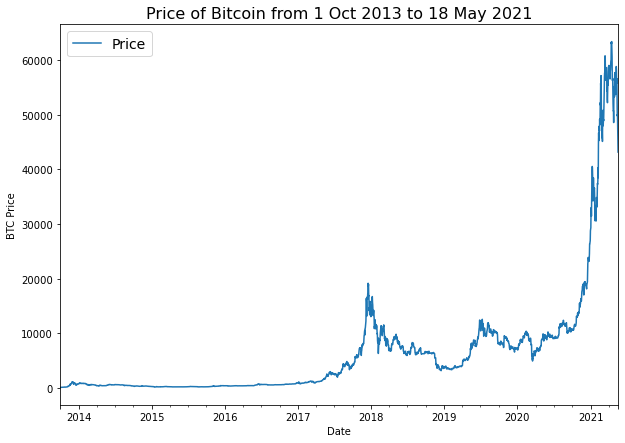

In [22]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [23]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

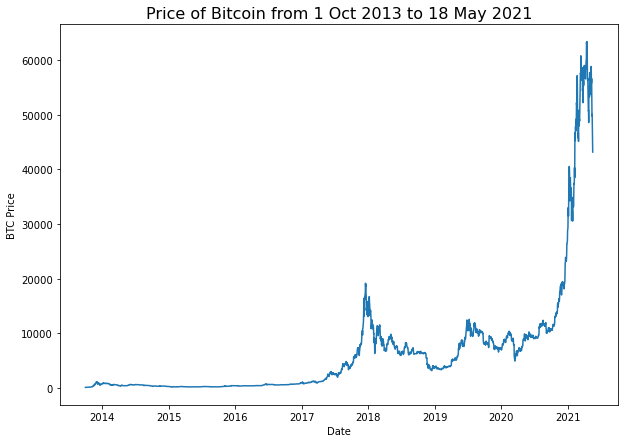

In [24]:
# Plot from CSV
import matplotlib.pyplot as plt
# import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [25]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [26]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [27]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

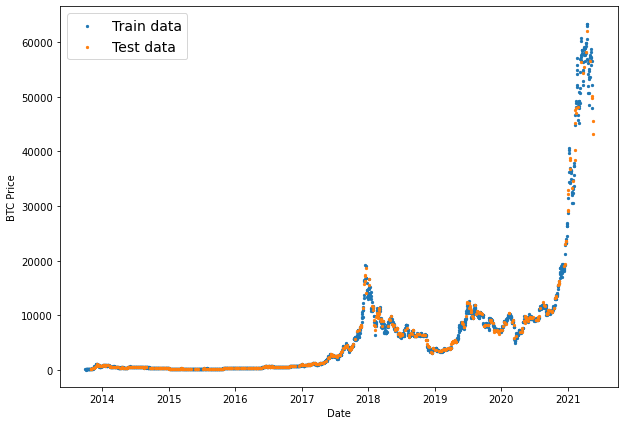

In [28]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [29]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

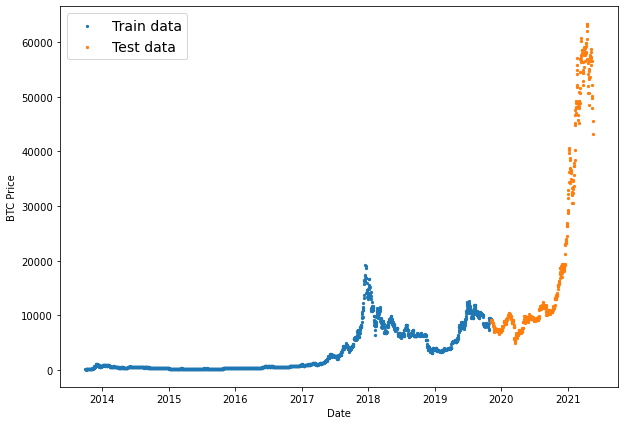

In [30]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [31]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None 
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

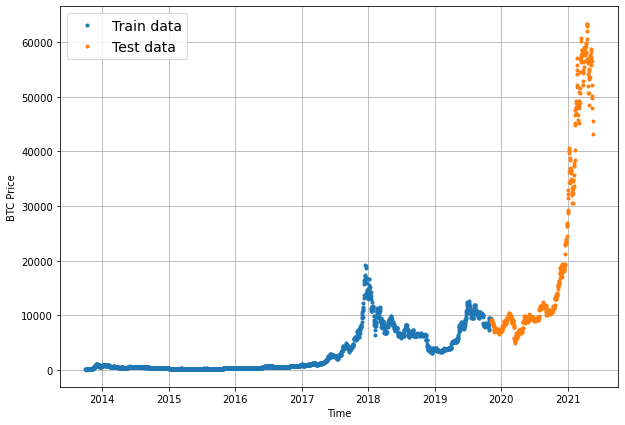

In [32]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0	Naïve model (baseline)	
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, 	horizon = 1, window = 30
* 3	Same as 1, 	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [33]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [34]:
# Create a naive forecast 
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

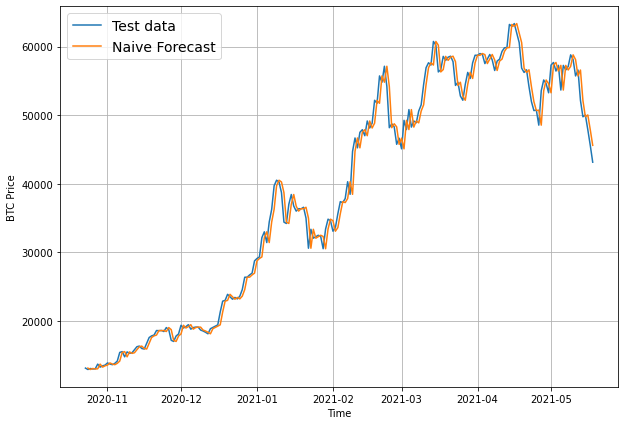

In [35]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

> 🛠 **Exercise:** Spend 10 minutes reading the [simple forecasts chapter of Forecasting: Principles in Practice](https://otexts.com/fpp3/simple-methods.html). And have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up? 

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting. 

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html) 

In [36]:
import tensorflow as tf

In [37]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [38]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182626

In [39]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function! 

Let's now see if it works...

In [40]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [41]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [42]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.63296373722>

In [43]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [44]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [45]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [46]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [47]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite lsow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon 

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [48]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horzion on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
        # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [49]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [50]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [51]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array 

## Turning windows into training and test sets

In [52]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [53]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of winodws and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [54]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [55]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [56]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [57]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [58]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32) 
* 100 epochs 

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [74]:
aux = pd.DataFrame(train_windows)
aux

,0,1,2,3,4,5,6
0,123.654990,125.455000,108.584830,118.674660,121.338660,120.655330,121.795000
1,125.455000,108.584830,118.674660,121.338660,120.655330,121.795000,123.033000
2,108.584830,118.674660,121.338660,120.655330,121.795000,123.033000,124.049000
3,118.674660,121.338660,120.655330,121.795000,123.033000,124.049000,125.961160
4,121.338660,120.655330,121.795000,123.033000,124.049000,125.961160,125.279660
...,...,...,...,...,...,...,...
2219,9458.223360,9455.724693,9225.995479,9131.410630,9197.632345,9290.896602,9202.415451
2220,9455.724693,9225.995479,9131.410630,9197.632345,9290.896602,9202.415451,9369.628081
2221,9225.995479,9131.410630,9197.632345,9290.896602,9202.415451,9369.628081,9326.599624
2222,9131.410630,9197.632345,9290.896602,9202.415451,9369.628081,9326.599624,9335.752402


In [72]:
test_labels.shape

(556, 1)

In [59]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation               
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 837.9736 - mae: 837.9736 - mse: 2698231.0000    

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 5s 151ms/step - loss: 731.2769 - mae: 731.2769 - mse: 2159357.7500 - val_loss: 870.7572 - val_mae: 870.7572 - val_mse: 2488672.5000
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 240.5693 - mae: 240.5693 - mse: 224299.1406 - val_loss: 939.6422 - val_mae: 939.6422 - val_mse: 2869478.2500
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 173.1205 - mae: 173.1205 - mse: 149865.4219 - val_loss: 1093.8706 - val_mae: 1093.8706 - val_mse: 3197417.5000
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 168.8138 - mae: 168.8138 - mse: 151248.0000

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 116ms/step - loss: 159.1660 - mae: 159.1660 - mse: 136986.2969 - val_loss: 849.7034 - val_mae: 849.7034 - val_mse: 2336256.0000
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 153.0923 - mae: 153.0923 - mse: 131228.7344

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 96ms/step - loss: 151.2405 - mae: 151.2405 - mse: 128564.6484 - val_loss: 841.6389 - val_mae: 841.6389 - val_mse: 2266567.0000
Epoch 6/100
18/18 [==============================] - 0s 15ms/step - loss: 150.5598 - mae: 150.5598 - mse: 125534.6328 - val_loss: 860.1775 - val_mae: 860.1775 - val_mse: 2264423.2500
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 149.2173 - mae: 149.2173 - mse: 125814.0156 - val_loss: 847.5103 - val_mae: 847.5103 - val_mse: 2203634.2500
Epoch 8/100
12/18 [===================>..........] - ETA: 0s - loss: 146.6898 - mae: 146.6898 - mse: 120718.7578

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 99ms/step - loss: 149.2313 - mae: 149.2313 - mse: 122486.9219 - val_loss: 807.8105 - val_mae: 807.8105 - val_mse: 2119881.7500
Epoch 9/100
14/18 [======================>.......] - ETA: 0s - loss: 145.6222 - mae: 145.6222 - mse: 117385.1875

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 103ms/step - loss: 148.4816 - mae: 148.4816 - mse: 120205.0312 - val_loss: 797.1016 - val_mae: 797.1016 - val_mse: 2061416.0000
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 142.2298 - mae: 142.2298 - mse: 109885.8750

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 98ms/step - loss: 147.3070 - mae: 147.3070 - mse: 120694.3750 - val_loss: 787.7751 - val_mae: 787.7751 - val_mse: 2018869.1250
Epoch 11/100
18/18 [==============================] - 0s 15ms/step - loss: 144.4607 - mae: 144.4607 - mse: 117207.4766 - val_loss: 808.4006 - val_mae: 808.4006 - val_mse: 2009141.8750
Epoch 12/100
18/18 [==============================] - 0s 15ms/step - loss: 144.3758 - mae: 144.3758 - mse: 116189.5938 - val_loss: 991.6784 - val_mae: 991.6784 - val_mse: 2666470.2500
Epoch 13/100
18/18 [==============================] - 0s 14ms/step - loss: 151.6655 - mae: 151.6655 - mse: 123020.5156 - val_loss: 830.2314 - val_mae: 830.2313 - val_mse: 2036480.8750
Epoch 14/100
18/18 [==============================] - 0s 11ms/step - loss: 139.6380 - mae: 139.6380 - mse: 110280.6641 - val_loss: 794.5246 - val_mae: 794.5246 - val_mse: 1920204.8750
Epoch 15/100
14/18 [======================>.......] - ETA: 0s - loss: 142.3145 - mae: 142.314

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 93ms/step - loss: 141.1237 - mae: 141.1237 - mse: 108845.7578 - val_loss: 744.9551 - val_mae: 744.9551 - val_mse: 1816166.6250
Epoch 16/100
18/18 [==============================] - 0s 13ms/step - loss: 136.4991 - mae: 136.4991 - mse: 105841.3438 - val_loss: 778.0204 - val_mae: 778.0204 - val_mse: 1851367.3750
Epoch 17/100
18/18 [==============================] - 0s 13ms/step - loss: 135.9957 - mae: 135.9957 - mse: 103638.7891 - val_loss: 797.0668 - val_mae: 797.0668 - val_mse: 1896588.6250
Epoch 18/100
12/18 [===================>..........] - ETA: 0s - loss: 139.3717 - mae: 139.3717 - mse: 107423.7188

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 108ms/step - loss: 134.9849 - mae: 134.9849 - mse: 103773.6172 - val_loss: 735.8268 - val_mae: 735.8268 - val_mse: 1730269.7500
Epoch 19/100
18/18 [==============================] - 0s 9ms/step - loss: 132.8458 - mae: 132.8458 - mse: 101157.5781 - val_loss: 754.1604 - val_mae: 754.1604 - val_mse: 1755621.1250
Epoch 20/100
18/18 [==============================] - 0s 10ms/step - loss: 132.7481 - mae: 132.7482 - mse: 101343.2266 - val_loss: 751.8184 - val_mae: 751.8184 - val_mse: 1739542.1250
Epoch 21/100
18/18 [==============================] - 0s 10ms/step - loss: 137.2787 - mae: 137.2787 - mse: 103836.6797 - val_loss: 759.3036 - val_mae: 759.3036 - val_mse: 1753307.8750
Epoch 22/100
15/18 [========================>.....] - ETA: 0s - loss: 134.3432 - mae: 134.3432 - mse: 104702.4141

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 98ms/step - loss: 130.4111 - mae: 130.4111 - mse: 97221.4375 - val_loss: 706.5168 - val_mae: 706.5168 - val_mse: 1620444.5000
Epoch 23/100
13/18 [====================>.........] - ETA: 0s - loss: 126.3979 - mae: 126.3979 - mse: 84672.6406

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 87ms/step - loss: 129.9870 - mae: 129.9870 - mse: 96000.6094 - val_loss: 698.9365 - val_mae: 698.9365 - val_mse: 1597047.5000
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 130.3983 - mae: 130.3983 - mse: 105118.9688

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 97ms/step - loss: 129.1482 - mae: 129.1482 - mse: 96069.2266 - val_loss: 694.8500 - val_mae: 694.8500 - val_mse: 1576804.8750
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 133.4763 - mae: 133.4763 - mse: 103025.6953

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 96ms/step - loss: 127.7729 - mae: 127.7729 - mse: 94088.2969 - val_loss: 689.3029 - val_mae: 689.3029 - val_mse: 1554275.2500
Epoch 26/100
11/18 [=================>............] - ETA: 0s - loss: 127.6201 - mae: 127.6201 - mse: 82170.6562

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 93ms/step - loss: 127.5063 - mae: 127.5063 - mse: 93188.4062 - val_loss: 677.8383 - val_mae: 677.8383 - val_mse: 1533424.1250
Epoch 27/100
13/18 [====================>.........] - ETA: 0s - loss: 130.6598 - mae: 130.6598 - mse: 98488.2891 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 96ms/step - loss: 127.9109 - mae: 127.9109 - mse: 92919.9141 - val_loss: 671.3399 - val_mae: 671.3399 - val_mse: 1515839.5000
Epoch 28/100
18/18 [==============================] - 0s 10ms/step - loss: 125.0225 - mae: 125.0225 - mse: 89435.0469 - val_loss: 692.1385 - val_mae: 692.1385 - val_mse: 1531061.0000
Epoch 29/100
18/18 [==============================] - 0s 10ms/step - loss: 123.5389 - mae: 123.5389 - mse: 88450.3672 - val_loss: 685.2871 - val_mae: 685.2871 - val_mse: 1509774.5000
Epoch 30/100
15/18 [========================>.....] - ETA: 0s - loss: 130.7363 - mae: 130.7363 - mse: 92787.7031

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 99ms/step - loss: 130.3498 - mae: 130.3498 - mse: 92325.5547 - val_loss: 656.8657 - val_mae: 656.8657 - val_mse: 1465202.6250
Epoch 31/100
18/18 [==============================] - 0s 10ms/step - loss: 122.3467 - mae: 122.3467 - mse: 86458.6797 - val_loss: 696.1080 - val_mae: 696.1080 - val_mse: 1521430.1250
Epoch 32/100
18/18 [==============================] - 0s 10ms/step - loss: 122.3141 - mae: 122.3141 - mse: 86867.7266 - val_loss: 685.5190 - val_mae: 685.5190 - val_mse: 1489570.7500
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 121.2001 - mae: 121.2001 - mse: 84483.1641 - val_loss: 666.6916 - val_mae: 666.6916 - val_mse: 1445551.3750
Epoch 34/100
14/18 [======================>.......] - ETA: 0s - loss: 124.3538 - mae: 124.3538 - mse: 94116.9531 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 117ms/step - loss: 121.3663 - mae: 121.3663 - mse: 86854.2188 - val_loss: 645.9828 - val_mae: 645.9828 - val_mse: 1400378.8750
Epoch 35/100
14/18 [======================>.......] - ETA: 0s - loss: 124.4112 - mae: 124.4112 - mse: 91136.8672

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 99ms/step - loss: 120.1852 - mae: 120.1852 - mse: 84462.1250 - val_loss: 635.7875 - val_mae: 635.7875 - val_mse: 1389193.6250
Epoch 36/100
10/18 [===============>..............] - ETA: 0s - loss: 116.3197 - mae: 116.3197 - mse: 79090.5078 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 112ms/step - loss: 121.6104 - mae: 121.6104 - mse: 83441.9688 - val_loss: 631.6418 - val_mae: 631.6418 - val_mse: 1371562.2500
Epoch 37/100
18/18 [==============================] - 0s 10ms/step - loss: 119.1941 - mae: 119.1941 - mse: 82972.9375 - val_loss: 645.8547 - val_mae: 645.8547 - val_mse: 1381215.2500
Epoch 38/100
18/18 [==============================] - 0s 10ms/step - loss: 117.8064 - mae: 117.8064 - mse: 82020.6406 - val_loss: 656.9855 - val_mae: 656.9855 - val_mse: 1396144.0000
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 121.5923 - mae: 121.5923 - mse: 86705.6719

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 93ms/step - loss: 117.8929 - mae: 117.8929 - mse: 81005.1562 - val_loss: 624.0160 - val_mae: 624.0160 - val_mse: 1343520.0000
Epoch 40/100
18/18 [==============================] - 0s 13ms/step - loss: 117.1426 - mae: 117.1426 - mse: 80924.5000 - val_loss: 642.7327 - val_mae: 642.7327 - val_mse: 1400803.6250
Epoch 41/100
10/18 [===============>..............] - ETA: 0s - loss: 123.7559 - mae: 123.7559 - mse: 88877.0859

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 105ms/step - loss: 116.7699 - mae: 116.7699 - mse: 80343.8750 - val_loss: 617.8071 - val_mae: 617.8071 - val_mse: 1318109.0000
Epoch 42/100
18/18 [==============================] - 0s 10ms/step - loss: 123.2083 - mae: 123.2083 - mse: 85468.2812 - val_loss: 670.9457 - val_mae: 670.9457 - val_mse: 1420822.8750
Epoch 43/100
18/18 [==============================] - 0s 9ms/step - loss: 122.8898 - mae: 122.8898 - mse: 80562.3984 - val_loss: 715.1968 - val_mae: 715.1968 - val_mse: 1624858.7500
Epoch 44/100
18/18 [==============================] - 0s 10ms/step - loss: 119.0995 - mae: 119.0995 - mse: 79417.2812 - val_loss: 619.3156 - val_mae: 619.3156 - val_mse: 1305358.8750
Epoch 45/100
14/18 [======================>.......] - ETA: 0s - loss: 111.9670 - mae: 111.9670 - mse: 71409.4922

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 100ms/step - loss: 114.5677 - mae: 114.5677 - mse: 77272.7812 - val_loss: 615.9633 - val_mae: 615.9633 - val_mse: 1295065.8750
Epoch 46/100
18/18 [==============================] - 0s 10ms/step - loss: 115.4613 - mae: 115.4613 - mse: 78436.9453 - val_loss: 636.2869 - val_mae: 636.2869 - val_mse: 1327631.0000
Epoch 47/100
18/18 [==============================] - 0s 10ms/step - loss: 116.1488 - mae: 116.1488 - mse: 78128.2734 - val_loss: 626.5417 - val_mae: 626.5417 - val_mse: 1306039.2500
Epoch 48/100
14/18 [======================>.......] - ETA: 0s - loss: 111.8664 - mae: 111.8664 - mse: 79567.5859

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 95ms/step - loss: 113.0980 - mae: 113.0980 - mse: 75961.8047 - val_loss: 602.2509 - val_mae: 602.2509 - val_mse: 1262570.6250
Epoch 49/100
18/18 [==============================] - 0s 13ms/step - loss: 117.3487 - mae: 117.3487 - mse: 79813.4062 - val_loss: 728.7200 - val_mae: 728.7200 - val_mse: 1548334.2500
Epoch 50/100
18/18 [==============================] - 0s 12ms/step - loss: 127.3526 - mae: 127.3526 - mse: 84184.4609 - val_loss: 622.8268 - val_mae: 622.8268 - val_mse: 1325400.3750
Epoch 51/100
18/18 [==============================] - 0s 10ms/step - loss: 114.4998 - mae: 114.4998 - mse: 77105.3750 - val_loss: 645.2073 - val_mae: 645.2073 - val_mse: 1336859.1250
Epoch 52/100
18/18 [==============================] - 0s 10ms/step - loss: 118.0844 - mae: 118.0844 - mse: 78719.2344 - val_loss: 604.6248 - val_mae: 604.6248 - val_mse: 1269258.2500
Epoch 53/100
18/18 [==============================] - 0s 11ms/step - loss: 114.7638 - mae: 114.763

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 98ms/step - loss: 113.5282 - mae: 113.5282 - mse: 75469.9453 - val_loss: 593.8942 - val_mae: 593.8942 - val_mse: 1235131.7500
Epoch 56/100
18/18 [==============================] - 0s 10ms/step - loss: 110.3210 - mae: 110.3210 - mse: 73532.3828 - val_loss: 661.8826 - val_mae: 661.8826 - val_mse: 1428919.1250
Epoch 57/100
18/18 [==============================] - 0s 9ms/step - loss: 110.9767 - mae: 110.9767 - mse: 74438.1328 - val_loss: 604.6885 - val_mae: 604.6885 - val_mse: 1247959.2500
Epoch 58/100
14/18 [======================>.......] - ETA: 0s - loss: 112.6470 - mae: 112.6470 - mse: 76761.6641

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 96ms/step - loss: 112.5534 - mae: 112.5534 - mse: 73496.3828 - val_loss: 589.6782 - val_mae: 589.6782 - val_mse: 1226011.1250
Epoch 59/100
18/18 [==============================] - 0s 13ms/step - loss: 110.1493 - mae: 110.1493 - mse: 73040.8125 - val_loss: 612.5162 - val_mae: 612.5162 - val_mse: 1288345.6250
Epoch 60/100
18/18 [==============================] - 0s 10ms/step - loss: 118.7279 - mae: 118.7279 - mse: 78375.5312 - val_loss: 670.8840 - val_mae: 670.8840 - val_mse: 1388576.2500
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 111.8900 - mae: 111.8900 - mse: 72943.0234 - val_loss: 594.3051 - val_mae: 594.3051 - val_mse: 1239576.3750
Epoch 62/100
16/18 [=========================>....] - ETA: 0s - loss: 110.3146 - mae: 110.3146 - mse: 72478.6719

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 84ms/step - loss: 108.7346 - mae: 108.7346 - mse: 70830.0234 - val_loss: 585.5676 - val_mae: 585.5676 - val_mse: 1206186.0000
Epoch 63/100
18/18 [==============================] - 0s 12ms/step - loss: 109.6089 - mae: 109.6089 - mse: 71966.6406 - val_loss: 593.7859 - val_mae: 593.7859 - val_mse: 1237665.1250
Epoch 64/100
18/18 [==============================] - 0s 12ms/step - loss: 111.0284 - mae: 111.0284 - mse: 73179.0391 - val_loss: 709.3505 - val_mae: 709.3505 - val_mse: 1480029.6250
Epoch 65/100
18/18 [==============================] - 0s 13ms/step - loss: 121.5157 - mae: 121.5157 - mse: 80800.0078 - val_loss: 633.4281 - val_mae: 633.4281 - val_mse: 1336908.6250
Epoch 66/100
18/18 [==============================] - 0s 12ms/step - loss: 112.5092 - mae: 112.5092 - mse: 73731.8672 - val_loss: 591.0754 - val_mae: 591.0754 - val_mse: 1208662.5000
Epoch 67/100
18/18 [==============================] - 0s 12ms/step - loss: 108.1148 - mae: 108.114

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 87ms/step - loss: 110.2777 - mae: 110.2777 - mse: 70889.1172 - val_loss: 580.7424 - val_mae: 580.7424 - val_mse: 1203742.8750
Epoch 72/100
18/18 [==============================] - 0s 10ms/step - loss: 110.9792 - mae: 110.9792 - mse: 72508.9688 - val_loss: 581.0542 - val_mae: 581.0542 - val_mse: 1204661.1250
Epoch 73/100
18/18 [==============================] - 0s 9ms/step - loss: 111.2096 - mae: 111.2096 - mse: 71419.1797 - val_loss: 605.5927 - val_mae: 605.5927 - val_mse: 1232521.3750
Epoch 74/100
13/18 [====================>.........] - ETA: 0s - loss: 109.4250 - mae: 109.4250 - mse: 71886.9688 

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 95ms/step - loss: 109.0873 - mae: 109.0873 - mse: 71152.1562 - val_loss: 579.1788 - val_mae: 579.1788 - val_mse: 1188678.6250
Epoch 75/100
11/18 [=================>............] - ETA: 0s - loss: 107.4384 - mae: 107.4384 - mse: 69330.1953

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 88ms/step - loss: 110.5333 - mae: 110.5333 - mse: 70621.5938 - val_loss: 577.8346 - val_mae: 577.8346 - val_mse: 1195960.5000
Epoch 76/100
18/18 [==============================] - 0s 10ms/step - loss: 111.0173 - mae: 111.0173 - mse: 71617.9062 - val_loss: 583.0151 - val_mae: 583.0151 - val_mse: 1190358.8750
Epoch 77/100
18/18 [==============================] - 0s 10ms/step - loss: 109.8601 - mae: 109.8601 - mse: 71192.7500 - val_loss: 590.6657 - val_mae: 590.6657 - val_mse: 1203147.5000
Epoch 78/100
18/18 [==============================] - 0s 12ms/step - loss: 110.6555 - mae: 110.6555 - mse: 69267.8750 - val_loss: 593.8083 - val_mae: 593.8083 - val_mse: 1236637.1250
Epoch 79/100
18/18 [==============================] - 0s 13ms/step - loss: 109.1914 - mae: 109.1914 - mse: 70703.2969 - val_loss: 601.7708 - val_mae: 601.7708 - val_mse: 1258861.1250
Epoch 80/100
18/18 [==============================] - 0s 11ms/step - loss: 113.8827 - mae: 113.882

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 1s 86ms/step - loss: 109.6767 - mae: 109.6767 - mse: 71632.3906 - val_loss: 570.7254 - val_mae: 570.7254 - val_mse: 1177405.5000
Epoch 86/100
13/18 [====================>.........] - ETA: 0s - loss: 104.6511 - mae: 104.6511 - mse: 59593.7969

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 98ms/step - loss: 109.6600 - mae: 109.6600 - mse: 69433.6875 - val_loss: 569.3626 - val_mae: 569.3626 - val_mse: 1172035.8750
Epoch 87/100
18/18 [==============================] - 0s 13ms/step - loss: 106.2462 - mae: 106.2462 - mse: 68957.2969 - val_loss: 622.5433 - val_mae: 622.5433 - val_mse: 1297776.1250
Epoch 88/100
18/18 [==============================] - 0s 11ms/step - loss: 111.8310 - mae: 111.8310 - mse: 72395.2734 - val_loss: 575.3038 - val_mae: 575.3038 - val_mse: 1191448.3750
Epoch 89/100
18/18 [==============================] - 0s 13ms/step - loss: 107.3642 - mae: 107.3642 - mse: 69024.1797 - val_loss: 617.1795 - val_mae: 617.1795 - val_mse: 1250344.8750
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 118.3874 - mae: 118.3874 - mse: 71604.3906 - val_loss: 789.5549 - val_mae: 789.5549 - val_mse: 1713596.0000
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 127.1062 - mae: 127.1062

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


18/18 [==============================] - 2s 113ms/step - loss: 110.7139 - mae: 110.7139 - mse: 71451.8281 - val_loss: 568.4436 - val_mae: 568.4436 - val_mse: 1171320.0000
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 114.8724 - mae: 114.8724 - mse: 70508.5938 - val_loss: 617.3197 - val_mae: 617.3197 - val_mse: 1254015.5000


In [60]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 617.3198 - mae: 617.3198 - mse: 1254015.5000


[617.31982421875, 617.31982421875, 1254015.5]

In [61]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 568.4435 - mae: 568.4435 - mse: 1171319.7500


[568.4435424804688, 568.4435424804688, 1171319.75]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions 

In [62]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [63]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 4ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8858.978, 8785.368, 9003.444, 8749.679, 8771.713, 8721.275,
        8689.331, 8506.085, 8473.834, 8516.587], dtype=float32)>)

In [64]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [65]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.44354,
 'mse': 1171319.4,
 'rmse': 1082.2751,
 'mape': 2.5572853,
 'mase': 0.99859786}

In [66]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [68]:
test_labels.shape

(556, 1)

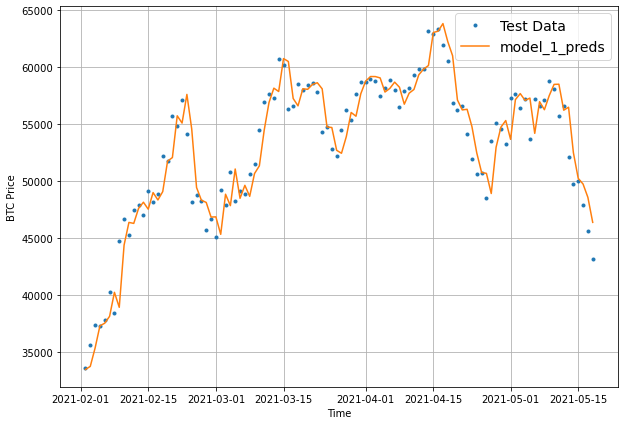

In [69]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

In [70]:
X_test.shape

(558,)

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

In [ ]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
tf.squeeze(test_labels).shape, model_2_preds.shape

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

In [ ]:
model_1_results

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)



In [ ]:
prices[:10]

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

In [ ]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

In [ ]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

In [ ]:
model_2_results

In [ ]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

In [ ]:
# Evaluate model_3 results (these are going multi-dimensional because we're trying to predict more than one timestep at a time)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

## Make our evaluation function work for larger horizons

In [ ]:
model_3.evaluate(test_windows, test_labels)

In [ ]:
tf.reduce_mean(model_3_results["mae"]).numpy()

In [ ]:
model_2_results["mae"].ndim

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

In [ ]:
model_3_preds[:5]

In [ ]:
test_labels[:]

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

In [ ]:
model_3_preds[0]

In [ ]:
tf.reduce_mean(model_3_preds[0])

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")

## Which of our models is performing the best so far? 

So we've trained a few models, now let's compare them and see how they've gone... 

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

> 📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDIW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output = ...?
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

In [ ]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.Dense(HORIZON)                      
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

In [ ]:
# Evaluate model... 
model_4.evaluate(test_windows, test_labels)

In [ ]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [ ]:
train_windows[:5]

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

In [ ]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# Let's make a multivariate time series 
bitcoin_prices.head()

In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

In [ ]:
bitcoin_prices_windowed.tail()

What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```



In [ ]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

In [ ]:
y.head()

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                          
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

In [ ]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

In [ ]:
model_1_results

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture 
* Potentially get state of the art results on our problem 

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models


In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance 

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7 

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf 

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks: 
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance) 

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])

In [ ]:
# Evaluate N-BEats model on the test dataset
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created 

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

### Constructing and fitting and ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models 

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

### Make predictions with our ensemble model

In [ ]:
ensemble_models

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

In [ ]:
ensemble_preds

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

In [ ]:
model_1_results

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialzed models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds 
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

> 📖 **Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post on [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

In [ ]:
X_test.index[:10]

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm... 

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> 🔑 **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty

Weve only scratched the surface of uncertainty in machine but if you'd like to learn more, I'd highly recommend checking out the resources located here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#learning-more-on-uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future! 

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

In [ ]:
bitcoin_prices_windowed.tail()

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

In [ ]:
X_all[:5], y_all[:5]

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimial performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions into future

In [ ]:
# How many timestesp to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
 * a list of values (Bitcoin historical data)
 * a trained model (such as `model_9`)
 * a window into the future to predict (our `INTO_FUTURE` variable)
 * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [ ]:
tf.expand_dims(y_all[-WINDOW_SIZE:], axis=0)

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

> 🛠 **Exercise:** In terms of a forecasting model, what might another approach to our make_future_forecasts() function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction.
>
> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.
>
> As it is, the make_future_forecasts() function skips the retraining of a model part.

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

### Plot future forecasts

In [ ]:
future_forecast

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
bitcoin_prices.index

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [ ]:
# Let's introduce a turkey prolbme to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500
                 )

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
model_1.summary()

### Build a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

In [ ]:
model_1_results

In [ ]:
plt.figure(figsize=(10, 7))
offset=0
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):], 
                 format="-",
                 label="Turkey Test Data", 
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);


## Compare models

In [ ]:
ensemble_results

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)                            

In [ ]:
# Sort model results by MAE and plot them 
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

## Exercises and extra curriculum

What a journey we've been on!

Thank you so much for following along.

For all the exercises and extra curriculum related to this section, please refer to the course GitHub: https://github.com/mrdbourke/tensorflow-deep-learning#course-materials